In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

openmc.config["cross_sections"] = (
    "/home/lucas/Documents/Proyecto_Integrador/endfb-viii.0-hdf5/cross_sections.xml"
)

# Atributos

In [2]:
vacio = False
fuente_energia = 'monoenergetica'
fuente_direccion = 'colimada'
source_file = None
# source_file = 'surface_source.h5'

L_x = 1.5  # cm dx del paralelepipedo
L_y = 1.5  # cm dy del paralelepipedo
L_z = 7  # cm

L_x_vacio = 0.3  # cm dx del vacio
L_y_vacio = 0.3  # cm dy del vacio

z0 = 4  # cm

# Defino materiales

In [3]:
mat_agua = openmc.Material()
mat_agua.add_nuclide("H1", 2.0, "ao")
mat_agua.add_nuclide("O16", 1.0, "ao")
mat_agua.add_s_alpha_beta("c_H_in_H2O")
mat_agua.set_density("g/cm3", 1)

mats = openmc.Materials([mat_agua])
mats.export_to_xml()

# Defino geometria

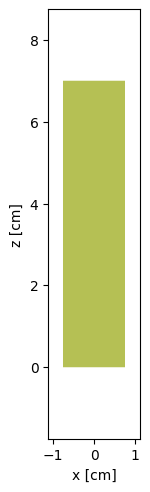

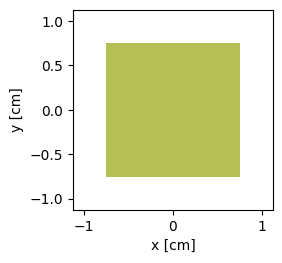

In [4]:
# 1-6: fronteras externas (vacuum)
sur001 = openmc.XPlane(x0=-L_x / 2, boundary_type="vacuum")
sur002 = openmc.XPlane(x0=L_x / 2, boundary_type="vacuum")
sur003 = openmc.YPlane(y0=-L_y / 2, boundary_type="vacuum")
sur004 = openmc.YPlane(y0=L_y / 2, boundary_type="vacuum")
sur005 = openmc.ZPlane(z0=0, boundary_type="vacuum")
sur006 = openmc.ZPlane(z0=L_z, boundary_type="vacuum")

# 7-10: fronteras internas (transmission)
sur007 = openmc.XPlane(x0=-L_x_vacio / 2, boundary_type="transmission")
sur008 = openmc.XPlane(x0=L_x_vacio / 2, boundary_type="transmission")
sur009 = openmc.YPlane(y0=-L_y_vacio / 2, boundary_type="transmission")
sur010 = openmc.YPlane(y0=L_y_vacio / 2, boundary_type="transmission")

# 11: surface track (transmission)
sur011 = openmc.ZPlane(z0=z0, boundary_type="transmission", surface_id=70)


if source_file is not None:
    sur005.translate(vector=(0, 0, z0-1e-6), inplace=True)

univ = openmc.Universe()

region1 = +sur001 & -sur002 & +sur003 & -sur004 & +sur005 & -sur006
region2 = +sur007 & -sur008 & +sur009 & -sur010 & +sur005 & -sur006

if vacio:
    if source_file is None:
        univ.add_cell(openmc.Cell(region=region1 & ~region2 & -sur011, fill=mat_agua, name="agua1"))
        univ.add_cell(openmc.Cell(region=region1 & ~region2 & +sur011, fill=mat_agua, name="agua2"))
        univ.add_cell(openmc.Cell(region=region2 & -sur011, fill=None, name="vacio1"))
        univ.add_cell(openmc.Cell(region=region2 & +sur011, fill=None, name="vacio2"))
    else:
        univ.add_cell(openmc.Cell(region=region1 & ~region2, fill=mat_agua, name="agua"))
        univ.add_cell(openmc.Cell(region=region2, fill=None, name="vacio"))
else:
    if source_file is None:
        univ.add_cell(openmc.Cell(region=region1 & -sur011, fill=mat_agua, name="agua1"))
        univ.add_cell(openmc.Cell(region=region1 & +sur011, fill=mat_agua, name="agua2"))
    else:
        univ.add_cell(openmc.Cell(region=region1, fill=mat_agua, name="agua"))

univ.plot(
    width=(1.5 * L_x, 1.5 * L_z),
    basis="xz",
    color_by="material",
)

univ.plot(
    width=(1.5 * L_x, 1.5 * L_y),
    basis="xy",
    color_by="material",
)

geom = openmc.Geometry(univ)
geom.export_to_xml()


# Defino fuente superficial

In [ ]:
source = openmc.IndependentSource()
source.particle = "neutron"

# Espatial distribution
x = openmc.stats.Uniform(-L_x / 2, L_x / 2)
y = openmc.stats.Uniform(-L_y / 2, L_y / 2)
z = openmc.stats.Discrete(1e-6, 1)
source.space = openmc.stats.CartesianIndependent(x, y, z)

# Energy distribution at 1 MeV
if fuente_energia == 'monoenergetica':
    source.energy = openmc.stats.Discrete([1e6],[1])

# Angle distribution collimated beam
if fuente_direccion == 'colimada':
    mu = openmc.stats.Discrete([1], [1])
    phi = openmc.stats.Uniform(0.0, 2 * np.pi)
    source.angle = openmc.stats.PolarAzimuthal(mu, phi)

settings = openmc.Settings()

# Write the particles that cross surface_track
if source_file is None:
    settings.surf_source_write = {"surface_ids": [70], "max_particles": 10000000}

settings.run_mode = "fixed source"
settings.batches = 40
settings.particles = 100000
settings.source = source if source_file is None else openmc.FileSource(source_file)
settings.export_to_xml()

# Defino tallies

In [6]:
# Initialize an empty tallies object
tallies = openmc.Tallies()

# Create a mesh of the parallelepiped to tally flux
mesh_flux = openmc.RectilinearMesh()
mesh_flux.x_grid = np.linspace(-L_x / 2, L_x / 2, 2)
mesh_flux.y_grid = np.linspace(-L_y/2, L_y/2, 2)
mesh_flux.z_grid = np.linspace(0, L_z, 100)

# Create mesh filter to tally flux
mesh_flux_filter = openmc.MeshFilter(mesh_flux)
mesh_flux_tally = openmc.Tally(name="flux")
mesh_flux_tally.filters = [mesh_flux_filter]
mesh_flux_tally.scores = ["flux"]
tallies.append(mesh_flux_tally)

# Print tallies
print(tallies)

# Export to "tallies.xml"
tallies.export_to_xml()

[Tally
	ID             =	1
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	
	Scores         =	['flux']
	Estimator      =	None
	Multiply dens. =	True]


# Corro la simulacion

In [ ]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

if source_file is None:
    !mv statepoint.*.h5 statepoing_original.h5
else:
    !mv statepoint.*.h5 statepoint_sintetico.h5

rm: cannot remove 'statepoint.*.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #####################

Proceso los tallies

In [8]:
# # Initialize an empty tallies object
# tallies = openmc.Tallies()

# # # Create a mesh of the parallelepiped to tally current
# # mesh_current = openmc.RectilinearMesh()
# # mesh_current.x_grid = np.linspace(-L_x / 2, L_x / 2, L_x * 4 + 1)
# # mesh_current.y_grid = np.linspace(-L_y / 2, L_y / 2, L_y * 4 + 1)
# # mesh_current.z_grid = np.linspace(0, L_z, L_z * 4 + 1)

# # # Create mesh filter to tally current
# # mesh_surface_filter = openmc.MeshSurfaceFilter(mesh_current)
# # mesh_surface_tally = openmc.Tally(name="current")
# # mesh_surface_tally.filters = [mesh_surface_filter]
# # mesh_surface_tally.scores = ["current"]
# # tallies.append(mesh_surface_tally)

# # Create a mesh of the parallelepiped to tally flux
# mesh_flux = openmc.RectilinearMesh()
# mesh_flux.x_grid = np.linspace(-L_x / 2, L_x / 2, 15)
# mesh_flux.y_grid = np.linspace(-0.1, 0.1, 2)
# mesh_flux.z_grid = np.linspace(0, L_z, 100)

# # Create mesh filter to tally flux
# mesh_flux_filter = openmc.MeshFilter(mesh_flux)
# mesh_flux_tally = openmc.Tally(name="flux")
# mesh_flux_tally.filters = [mesh_flux_filter]
# mesh_flux_tally.scores = ["flux"]
# tallies.append(mesh_flux_tally)

# # Create a mesh of the parallelepiped to tally flux
# mesh_flux = openmc.RectilinearMesh()
# mesh_flux.x_grid = np.linspace(-L_x / 2, L_x / 2, 2)
# mesh_flux.y_grid = np.linspace(-L_y/2, L_y/2, 2)
# mesh_flux.z_grid = np.linspace(0, L_z, 100)

# # Create mesh filter to tally flux
# mesh_flux_filter = openmc.MeshFilter(mesh_flux)
# mesh_flux_tally = openmc.Tally(name="flux2")
# mesh_flux_tally.filters = [mesh_flux_filter]
# mesh_flux_tally.scores = ["flux"]
# tallies.append(mesh_flux_tally)

# # Print tallies
# print(tallies)

# # Export to "tallies.xml"
# tallies.export_to_xml()

In [9]:
# # Load the statepoint file
# sp = openmc.StatePoint("statepoint.40.h5")

In [10]:
# tally = sp.get_tally(name="current")
# df = tally.get_pandas_dataframe()
# df.columns = ["x", "y", "z", "surf", "nuclide", "score", "mean", "std.dev."]

# # Get the mesh
# mesh = tally.find_filter(openmc.MeshSurfaceFilter).mesh
# XX, YY = np.meshgrid(
#     (mesh.x_grid[1:] + mesh.x_grid[:-1]) / 2.0,
#     (mesh.y_grid[1:] + mesh.y_grid[:-1]) / 2.0,
# )

In [11]:
# def plot_current(df, surf, z, XX, YY, vmin=None, vmax=None):
#     # Filter by surface
#     filtered_df = df.query(f"surf == '{surf}'")

#     # Filter by z value
#     filtered_df = filtered_df.query(f"z == {z}")

#     # Get the current
#     current = filtered_df["mean"].values
#     current = current.reshape(XX.shape)

#     # Plot the current
#     plt.pcolormesh(
#         XX,
#         YY,
#         current,
#         shading="gouraud",
#         cmap=mpl.colormaps["jet"],
#         vmin=vmin,
#         vmax=vmax,
#     )
#     plt.colorbar()
#     plt.title(f"{surf} at z = {z}")
#     plt.xlabel("x [cm]")
#     plt.ylabel("y [cm]")
#     plt.show()

In [12]:
# v_max = 1.5e-4
# v_min = 0

# # plot_current(df, "z-min in", 1, XX, YY) # z-min in at 1 means z = 0cm, z-min in at z = 2 means z = 5cm
# # plot_current(df, "z-min out", 1, XX, YY)
# plot_current(df, "z-min in", 2, XX, YY, vmin=v_min, vmax=v_max)
# # plot_current(df, "z-min out", 2, XX, YY)
# plot_current(df, "z-min in", 3, XX, YY, vmin=v_min, vmax=v_max)
# # plot_current(df, "z-min out", 3, XX, YY)
# plot_current(df, "z-min in", 4, XX, YY, vmin=v_min, vmax=v_max)
# # plot_current(df, "z-min out", 4, XX, YY)
# plot_current(df, "z-min in", 5, XX, YY, vmin=v_min, vmax=v_max)

In [13]:
# tally = sp.get_tally(name="flux")
# df = tally.get_pandas_dataframe()
# # print(df.head(20))
# df.columns = ["x", "y", "z", "nuclide", "score", "mean", "std.dev."]

# # Filter the DataFrame to include only z <= 40 cm
# df_filtered = df[df["z"] <= 20]

# # Get the mesh
# mesh = tally.find_filter(openmc.MeshFilter).mesh
# x_centers = (mesh.x_grid[1:] + mesh.x_grid[:-1]) / 2.0
# z_centers = (mesh.z_grid[1:] + mesh.z_grid[:-1]) / 2.0

# # Filter the mesh grid to include only z <= 40 cm
# z_centers_filtered = z_centers[z_centers <= 20]
# XX_filtered, ZZ_filtered = np.meshgrid(x_centers, z_centers_filtered)

# # Filter the flux values to match the filtered mesh grid
# flux_filtered = df_filtered["mean"].values
# flux_filtered.shape = (len(z_centers_filtered), len(x_centers))

# # Plot the flux
# plt.pcolormesh(
#     XX_filtered, ZZ_filtered, flux_filtered, shading="gouraud", cmap=plt.get_cmap("jet")
# )
# plt.colorbar()
# plt.title("Flux")
# plt.xlabel("x [cm]")
# plt.ylabel("z [cm]")
# plt.show()

# # # Get the mesh
# # mesh = tally.find_filter(openmc.MeshFilter).mesh
# # XX, ZZ = np.meshgrid(
# #     (mesh.x_grid[1:] + mesh.x_grid[:-1]) / 2.0,
# #     (mesh.z_grid[1:] + mesh.z_grid[:-1]) / 2.0,
# # )

# # # Plot the flux
# # flux = df["mean"].values
# # flux.shape = np.shape(XX)
# # plt.pcolormesh(XX, ZZ, flux, shading="nearest", cmap=mpl.colormaps["jet"])
# # plt.colorbar()
# # plt.title("Flux")
# # plt.xlabel("x [cm]")
# # plt.ylabel("z [cm]")
# # plt.show()

In [14]:
# # Load the statepoint file
# sp = openmc.StatePoint("statepoint.40.h5")
# tally = sp.get_tally(name="current at x = 0.5 and x = -0.5")
# df = tally.get_pandas_dataframe()
# df.columns = ["x", "y", "z", "surf", "nuclide", "score", "mean", "std.dev."]

# # Busco el filtro mesh del tally, y saco la grilla de ahi
# mesh = tally.find_filter(openmc.MeshSurfaceFilter).mesh
# YY, ZZ = np.meshgrid(
#     (mesh.y_grid[1:] + mesh.y_grid[:-1]) / 2.0,
#     (mesh.z_grid[1:] + mesh.z_grid[:-1]) / 2.0,
# )

# # Filtro los x+ entrantes: --|-->      |
# filtered_df = df.query('surf == "x-min in"')
# current_xmin_plus = filtered_df["mean"].values
# current_xmin_plus.shape = np.shape(YY)

# # Plot the current
# plt.pcolormesh(YY, ZZ, current_xmin_plus, shading="nearest", cmap=mpl.colormaps["jet"])
# plt.colorbar()
# plt.title("--|-->      |")
# plt.xlabel("y [cm]")
# plt.ylabel("z [cm]")
# plt.show()

# # Filtro los x- salientes: <--|--      |
# filtered_df = df.query('surf == "x-min out"')
# current_xmin_minus = filtered_df["mean"].values
# current_xmin_minus.shape = np.shape(YY)

# # Plot the current
# plt.pcolormesh(YY, ZZ, current_xmin_minus, shading="nearest", cmap=mpl.colormaps["jet"])
# plt.colorbar()
# plt.title("<--|--      |")
# plt.xlabel("y [cm]")
# plt.ylabel("z [cm]")
# plt.show()

# # Filtro los x+ salientes:      |  --|-->
# filtered_df = df.query('surf == "x-max out"')
# current_xmax_plus = filtered_df["mean"].values
# current_xmax_plus.shape = np.shape(YY)

# # Plot the current
# plt.pcolormesh(YY, ZZ, current_xmax_plus, shading="nearest", cmap=mpl.colormaps["jet"])
# plt.colorbar()
# plt.title("      |  --|-->")
# plt.xlabel("y [cm]")
# plt.ylabel("z [cm]")
# plt.show()

# # Filtro los x- entrantes:      |  <--|--
# filtered_df = df.query('surf == "x-max in"')
# current_xmax_minus = filtered_df["mean"].values
# current_xmax_minus.shape = np.shape(YY)

# # Plot the current
# plt.pcolormesh(YY, ZZ, current_xmax_minus, shading="nearest", cmap=mpl.colormaps["jet"])
# plt.colorbar()
# plt.title("      |  <--|--")
# plt.xlabel("y [cm]")
# plt.ylabel("z [cm]")
# plt.show()